In [1]:
from torch.utils.benchmark import Timer
import torch.nn as nn
import torch.nn.functional as F
import math
from LION import Lion
import pandas as pd
import medmnist
import glob, PIL
device = 'cuda'
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
%matplotlib inline
from BcosMy import *
import sklearn.model_selection as sk

In [2]:
truths = pd.read_csv('GroundTruth.csv', index_col='image')
tr, te = sk.train_test_split(truths, test_size=0.15, random_state=1, stratify=truths)
#s = torch.tensor([2.4544, 1.0000, 3.6113, 4.5277, 2.4702, 7.6258, 6.8914])
tr = tr.sum()
s = 1 / (tr / tr.sum())
s = torch.tensor(s) ** 0.5
m = torch.tensor(tr)
v = m * s
v.sum() / m.sum()

tensor(2.1162, dtype=torch.float64)

In [3]:
class Cancer(torch.utils.data.Dataset):
    def __init__(self, split, transform=None):
        truths = pd.read_csv('GroundTruth.csv', index_col='image')
        tr, te = sk.train_test_split(truths, test_size=0.15, random_state=1, stratify=truths)
        if split == 'train':
            data = tr
        else:
            data = te

        self.data = []
        self.transforms = transform

        for img, y in data.iterrows():
            y = torch.tensor(y)
            self.data.append((f'images/{img}.jpg', y))
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, l = self.data[idx]
        img = PIL.Image.open(img)
        if self.transforms != None:
            img = self.transforms(img)
        return img, l

In [4]:
img = 134
transfs = transforms.Compose([transforms.Resize((img)), 
                              transforms.CenterCrop((img, img)), 
                              transforms.RandomHorizontalFlip(), 
                              #transforms.RandAugment(4, 9),
                              transforms.RandAugment(3, 3),
                              transforms.ToTensor()])

transfsTe = transforms.Compose([transforms.Resize((img)), 
                              transforms.CenterCrop((img, img)), 
                              transforms.ToTensor()])

train = Cancer('train', transform=transfs)
test = Cancer('test', transform=transfsTe)
trainTe = Cancer('train', transform=transfsTe)
num_classes = 7
imagi = transforms.ToPILImage()

In [5]:
class FeatScale(nn.Module):
    def __init__(self, emb):
        super().__init__()
        self.gamma1 = nn.Parameter(torch.ones(emb))
        self.gamma2 = nn.Parameter(torch.ones(emb))

    def forward(self, x):
        DC = x.mean(1, keepdim=True)
        return DC * self.gamma1 + (x - DC) * self.gamma2

In [8]:
def B(img, p, kern):
    B = torch.zeros(1, p, img, img)
    wind = kern**2
    B = F.unfold(B, kern, stride=1, padding=kern//2)
    B = B.view(p, wind, p)
    B[torch.arange(p), :, torch.arange(p)] = 30
    B[torch.arange(p), wind//2, torch.arange(p)] = -20
    B = B.flatten(0, 1)
    B = F.fold(B, (img, img), kern, padding=kern//2)

    field = torch.arange(img).unsqueeze(0).expand([img, -1])
    field = (field - (img-1)/2).abs()
    field = field + field.mT
    B /= field+1e-1
    B += 0.1
    return B.flatten(-2)

In [9]:
class MSA(nn.Module):
    def __init__(self, emb, heads, img):
        super().__init__()
        self.heads = heads
        self.hid = emb//heads
        self.add_module('norm', LNorm1d(emb))
        self.add_module('qk', nn.Linear(emb, 2*emb, bias=False))
        self.detach = False
        self.gammaB = nn.Parameter(B(img, img**2, 5).unsqueeze(0))
        self.add_module('v', BLinear(emb, emb))

        self.gamma = nn.Parameter(torch.ones(1, heads, 1, 1))
        self.add_module('soft', nn.Softmax(-1))
        self.add_module('scale', FeatScale(emb))
                        
    def forward(self, x):
        x, m = x
        b, p, c = x.shape
        h = self.heads
        e = self.hid
        if self.training:
            rh = h//2
        else:
            rh = h
        
        brang = torch.arange(b).unsqueeze(-1)
        mask = self.drop(b, h)

        B = self.soft(self.gammaB)
        B = B.expand([b, -1, -1])
        if m != None:
            B = B[brang.unsqueeze(-1), m.unsqueeze(-1), m.unsqueeze(-2)]
        B = B.unsqueeze_(1)
        B = B.expand([-1, rh, -1, -1]).flatten(0,1)

        qk = self.qk(self.norm(x)).view(b, p, 2, h, e).permute(2, 0, 3, 1, 4)
        if self.detach:
            qk = qk.detach()
        v = self.v(x).view(b, p, h, e)
        v.transpose_(1, 2)
        s = self.gamma.expand([b, -1, -1, -1])
         
        if self.training:
            qk = qk[:, brang, mask]
            v = v[brang, mask]
            s = s[brang, mask]

        qk = qk.flatten(1, 2)
        v = v.flatten(0, 1)
        s = s.flatten(0, 1)

        qk = F.normalize(qk, p=2, dim=-1)
        q, k, = qk[0], qk[1]

        att = self.soft(q @ k.mT * s)
        att = att * torch.gt(att, att.amax(dim=-1, keepdim=True) * 0.1)
        att /= att.sum(-1, keepdim=True)
        att *= B * 2

        avg = (att @ v).unflatten(0, (b, rh))

        if self.training:
            zeros = torch.zeros(b, h, p, e, device=x.device)
            zeros[brang, mask] = avg
            avg = zeros * 2
        
        avg.transpose_(1, 2)
        avg = avg.flatten(-2)
        avg = self.scale(avg)
        
        return avg


    def drop(self, b, h):
        mask = torch.rand(b, h)
        mask = torch.argsort(mask, dim=1)
        mask = mask[:, :h//2]
        return mask

In [10]:
class Block(nn.Module):
    def __init__(self, emb, expansion, heads, img):
        super().__init__()
        self.add_module('att', MSA(emb, heads, img))
        self.add_module('norm2', LNorm1d(emb))
        self.add_module('mlp', MLP(emb, expansion))
        self.add_module('dp', nn.Dropout(0.5, True))
        self.gamma1 = nn.Parameter(torch.tensor([0.2]))
        self.gamma2 = nn.Parameter(torch.tensor([0.2]))

    def forward(self, x):
        x, m = x
        x = x + self.att((x, m)) * self.gamma1
        x = x + self.dp(self.mlp(self.norm2(x)) * self.gamma2)
        return (x, m)

In [11]:
class Tokenize(nn.Module):
    def __init__(self, emb, fin, heads, img, wind):
        super().__init__()
        self.heads = heads
        self.hid = fin//heads
        self.p = img**2
        self.ci = emb
        w2 = wind*2
        self.wp = w2**2
        self.ws = self.p // self.wp
        self.add_module('unfold1', nn.Unfold((2, 2), stride=(2, 2)))
        self.add_module('unfold2', nn.Unfold((w2, w2), stride=(w2, w2)))
        t = img//wind
        self.add_module('fold', nn.Fold((t, t), (2, 2), stride=(2, 2)))
        self.add_module('norm1', LNorm1d(fin))
        self.add_module('norm2', LNorm1d(emb))
        self.add_module('q', nn.Linear(fin, fin, bias=False))
        self.add_module('k', nn.Linear(emb, fin, bias=False))
        self.detach = False
        self.add_module('v', BLinear(emb, fin))

        self.gamma = nn.Parameter(torch.ones(1, heads, 1, 1, 1))
        self.add_module('soft', nn.Softmax(-1))
        self.add_module('scale', FeatScale(fin))
                        
    def forward(self, x):
        toks, x = x
        ci = self.ci
        b, c, i, _ = toks.shape
        h = self.heads
        e = self.hid
        ws = self.ws
        wp = self.wp 
        if self.training:
            rh = h//2
        else:
            rh = h
        
        brang = torch.arange(b).unsqueeze(-1)
        mask = self.drop(b, h)
        toks = self.unfold1(toks).view(b, 4, c, ws).movedim(3, 1)
        x = self.unfold2(x).view(b, wp, ci, ws).movedim(3, 1)

        q = self.q(self.norm1(toks)).view(b, ws, 4, h, e).permute(0, 3, 1, 2, 4)

        k = self.k(self.norm2(x)).view(b, ws, wp, h, e).permute(0, 3, 1, 2, 4)

        v = self.v(x).view(b, ws, wp, h, e).permute(0, 3, 1, 2, 4)

        s = self.gamma.expand([b, -1, ws, -1, -1])

        if self.detach:
            q = q.detach()
            k = k.detach()


        if self.training:
            q = q[brang, mask]
            k = k[brang, mask]
            v = v[brang, mask]
            s = s[brang, mask]

        q = q.flatten(0, 2)
        k = k.flatten(0, 2)
        v = v.flatten(0, 2)
        s = s.flatten(0, 2)

        q = F.normalize(q, p=2, dim=-1)
        k = F.normalize(k, p=2, dim=-1)
        
        att = self.soft(q @ k.mT * s)
        att = att * torch.ge(att, att.amax(dim=-1, keepdim=True) * 0.1)
        att /= att.sum(-1, keepdim=True)

        avg = att @ v
        avg = avg.view(b, rh, ws, 4, e)

        if self.training:
            zeros = torch.zeros(b, h, ws, 4, e, device=x.device)
            zeros[brang, mask] = avg
            avg = zeros * 2

        avg = avg.permute(0, 1, 4, 3, 2).flatten(1, 3)
        avg = self.fold(avg).flatten(-2).mT
        avg = self.scale(avg)
        
        return avg
    

    def drop(self, b, h):
        mask = torch.rand(b, h)
        mask = torch.argsort(mask, dim=1)
        mask = mask[:, :h//2]
        return mask

In [12]:
class Embed(nn.Module):
    def __init__(self, ch, emb, fin, heads, img, wind):
        super().__init__()
        self.add_module('stem', BConv2d(ch, emb, 7, 0, 1, maxout=2))
        self.add_module('pool', nn.AvgPool2d(2, 2))
        self.add_module('norm1', LNorm2d(emb))
        self.add_module('conv1', BConv2d(emb, int(emb*1.5), 3, 0, 1, maxout=2))
        emb = int(emb*1.5)
        self.add_module('norm2', LNorm2d(emb))
        self.add_module('conv2', BConv2d(emb, int(emb*1.5), 3, 0, 1, maxout=2))
        emb = int(emb*1.5)
        #self.add_module('norm3', LNorm2d(emb))
        #self.add_module('conv3', BConv2d(emb, int(emb*1.5), 3, 0, 1, maxout=2))
        #emb = int(emb*1.5)

        self.add_module('cnorm', LNorm2d(emb))
        self.add_module('patch', BConv2d(emb, fin, wind, 0, wind, maxout=2))

    def forward(self, x):
        x = self.stem(x)
        x = self.pool(x)
        x = self.conv1(self.norm1(x))
        x = self.conv2(self.norm2(x))
        #x = self.conv3(self.norm3(x))
        x = self.cnorm(x)
        x = self.patch(x).flatten(-2).mT
        if self.training:
            x = self.drop(x)
        else:
            x = (x, None)
        return x

    def drop(self, x):
        b, p, c = x.shape
        mask = torch.rand(b, p, device=x.device)
        mask = torch.argsort(mask, dim=1)
        #ratio = int(p*0.4)
        mask = mask[:, :p//2]
        x = torch.gather(x, 1, mask.unsqueeze(-1).expand([-1, -1, c]))
        return (x, mask)

In [13]:
class ViT(nn.Module):
    def __init__(self, img, ch, emb, fin, expansion, heads, classes, wind):
        super().__init__()

        red = 0
        #img -= 6
        #img = (img-4)//2 - 4
        img = (img-6)//2 - 4
        self.add_module('stem', Embed(ch, emb, fin, heads, img, wind))
        img //= wind
        emb = fin
        red += 4

        self.add_module('att', nn.Sequential())

        self.att.add_module('block1', Block(emb, expansion, heads, img))
        red += 3


        self.att.add_module('block2', Block(emb, expansion, heads, img))
        red += 3


        self.att.add_module('block3', Block(emb, expansion, heads, img))
        red += 3


        self.att.add_module('block4', Block(emb, expansion, heads, img))
        red += 3


        self.att.add_module('block5', Block(emb, expansion, heads, img))
        red += 3


        self.att.add_module('block6', Block(emb, expansion, heads, img))
        red += 3


        self.att.add_module('block7', Block(emb, expansion, heads, img))
        red += 3


        self.att.add_module('block8', Block(emb, expansion, heads, img))
        red += 3


        self.att.add_module('block9', Block(emb, expansion, heads, img))
        red += 3


        self.att.add_module('block10', Block(emb, expansion, heads, img))
        red += 3


        self.att.add_module('block11', Block(emb, expansion, heads, img))
        red += 3


        self.att.add_module('block12', Block(emb, expansion, heads, img))
        red += 3


        #self.att.add_module('block13', Block(emb, expansion, heads, img))
        #red += 3


        #self.att.add_module('block14', Block(emb, expansion, heads, img))
        #red += 3


        #self.att.add_module('block15', Block(emb, expansion, heads, img))
        #red += 3


        #self.att.add_module('block16', Block(emb, expansion, heads, img))
        #red += 3


        #self.att.add_module('block17', Block(emb, expansion, heads, img))
        #red += 3


        #self.att.add_module('block18', Block(emb, expansion, heads, img))
        #red += 3


        #self.att.add_module('block19', Block(emb, expansion, heads, img))
        #red += 3


        #self.att.add_module('block20', Block(emb, expansion, heads, img))
        #red += 3


        #self.att.add_module('block21', Block(emb, expansion, heads, img))
        #red += 3


        #self.att.add_module('block22', Block(emb, expansion, heads, img))
        #red += 3


        #self.att.add_module('block23', Block(emb, expansion, heads, img))
        #red += 3


        #self.att.add_module('block24', Block(emb, expansion, heads, img))
        #red += 3


        #self.att.add_module('block25', Block(emb, expansion, heads, img))
        #red += 3


        #self.att.add_module('block26', Block(emb, expansion, heads, img))
        #red += 3

        #self.register_buffer('s', torch.tensor([2.4544, 1.0000, 3.6113, 4.5277, 2.4702, 7.6258, 6.8914]))
        #self.register_buffer('s', torch.tensor([2.9996, 1.2221, 4.4134, 5.5334, 3.0189, 9.3197, 8.4222]))

        self.add_module('classifier', BLinear(emb, classes))
        red += 1

        self.losses = []
        self.accs = []

        self.classes = classes

        self.register_buffer('gamma', torch.tensor([1/(red*90)]))
        self.register_buffer('b', -(torch.ones(classes)*(classes-1)).log())

        for name, mod in self.named_modules():
            if 'fc1.linear' in name:
                nn.init.kaiming_normal_(mod.weight, a=0, mode='fan_out')
            elif 'fc2.linear' in name:
                nn.init.kaiming_normal_(mod.weight, a=0, mode='fan_in')


    def cat(self, x):
        with torch.no_grad():
            return torch.cat((x, 1-x), 1)
    

    def forward(self, x):
        x = self.stem(x)
        x = self.att(x)[0].mean(1)
        x = self.classifier(x) * self.gamma
        if self.training:
            x = x + self.b
        return x


    def explain(self, x, y=None):
        self.zero_grad(True)
        orig = x.movedim(0, 2)

        x = self.cat(x.unsqueeze(0)).to(device)
        x.requires_grad_(True)

        self.eval()
        self.switch(True)

        logits = self(x)[0]
        pred = logits.argmax()

        if y != None:
            arg = y.argmax()
            logit = logits[arg]

        else:
            logit = logits[pred]

        logit.backward(inputs=[x])
        heat = x.grad.detach()[0].cpu()
        x = x.detach()[0].cpu()
        contribs = (heat * x).sum(0, keepdim=True)

        rgb_g = heat / (heat.abs().max(0, keepdim=True).values + 1e-12)
        rgb_g = rgb_g.clamp(min=0)
        rgb_g = rgb_g[:3] / (rgb_g[:3] + rgb_g[3:] + 1e-12)
        alpha = heat.norm(dim=0, keepdim=True)
        alpha = torch.where(contribs < 0, 1e-12, alpha)
        smooth = 1
        alpha = F.avg_pool2d(alpha, smooth, stride=1, padding=(smooth -1)//2)
        alpha = (alpha / torch.quantile(alpha, q=99.5/100)).clip(0, 1)
        rgba = torch.cat([rgb_g, alpha], dim=0).movedim(0, 2)
        
        self.switch(False)
        self.train()

        return (rgba, contribs[0], orig)


    def switch(self, explain):
        for mod in self.modules():
            if isinstance(mod, (BConv2d, BLinear, LNorm1d, LNorm2d, MSA, BConv2dGroup, Bconv2dPoint, Tokenize)):
                if explain:
                    mod.detach = True
                else:
                    mod.detach = False


    def fit(self, train, test, batch_size, epochs=2, lr=1e-4, wd=0.1, pre=10, min=1e-5, mult=1):
        train = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, pin_memory=True)
        test = torch.utils.data.DataLoader(test, batch_size=batch_size, pin_memory=True)
        iters = len(train)

        grs = self.group(wd, lr)
        optimizer = Lion(**grs['decayed'])
        optimizer.add_param_group(grs['notdecayed'])
        #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10, 1e-5)
        #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, pre, mult, min)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 1e-3, epochs=epochs, steps_per_epoch=iters)

        for epoch in range(epochs):

            for i, batch in enumerate(train):
            #for batch in train:
                x = batch[0].to(device)
                x = self.cat(x)
                y = batch[1].to(device)

                logits = self(x)
                
                #loss = F.binary_cross_entropy_with_logits(logits, y, pos_weight=self.s)
                loss = F.binary_cross_entropy_with_logits(logits, y)

                optimizer.zero_grad(True)
                loss.backward()
                optimizer.step()
                scheduler.step(epoch + i / iters)
                #scheduler.step()


            with torch.no_grad():
            
                self.eval()
                loss = 0.0
                acc = 0.0
                tot = 0.0

                for batch in test:

                    x = batch[0].to(device)
                    x = self.cat(x)
                    y = batch[1].to(device)
                    
                    logits = self(x)
                    
                    loss += F.binary_cross_entropy_with_logits(logits, y)
                    acc += (torch.argmax(logits, -1) == torch.argmax(y, -1)).sum()
                    tot += y.shape[0]
                    
                loss /= len(test)
                acc /= tot 
                self.losses.append(loss.item())
                self.accs.append(acc.item())
                ep = epoch+1
                print(f'epoch {ep} | Test | loss {loss:.4f} | acc {(acc * 100):.4f}%')
                self.train()
                print('')

            if ep % 10 == 0:
                torch.save(self.losses, 'curloss')
                torch.save(self.accs, 'curacc')
                torch.save(self.state_dict(), 'curdict')


    def group(self, decay, lr):
        strs = ['gamma']

        grs = {'decayed': 
               {'params': [],
                'lr': lr,
                'betas': (0.9, 0.99),
                'weight_decay': decay},

               'notdecayed': 
               {'params': [],
                'lr': lr,
                'betas': (0.9, 0.99),
                'weight_decay': 0}}
        
        for mod in self.named_parameters():

            if any(string in mod[0] for string in strs):
                grs['notdecayed']['params'].append(mod[1])

            else:
                grs['decayed']['params'].append(mod[1])

        return grs

In [14]:
dictio = {
    '0' : 'меланома',
    '1' : 'меланоцитарные невусы',
    '2' : 'базально-клеточная карцинома',
    '3' : 'Актинические кератозы и внутриэпителиальная карцинома',
    '4' : 'доброкачественные образования, похожие на кератоз',
    '5' : 'дерматофиброма',
    '6' : 'сосудистые поражения'
}
names = dictio.values()

In [13]:
net = ViT(img, 6, 36, 256, 4, 4, num_classes, 5).to(device)
net.load_state_dict(torch.load('dictWEIGHT'))
net.losses = torch.load('lossesWEIGHT')
net.accs = torch.load('accsWEIGHT')

In [12]:
net = ViT(img, 6, 36, 256, 4, 4, num_classes, 5).to(device)
net.load_state_dict(torch.load('curdict'))
net.losses = torch.load('curloss')
net.accs = torch.load('curacc')

In [15]:
net = ViT(img, 6, 36, 256, 4, 4, num_classes, 5).to(device)
print(sum(p.nelement() for p in net.parameters()))

net.fit(train, test, 100, 300, wd=1, lr= 1e-4 , min=3e-5, pre=10)

KeyboardInterrupt: 

In [13]:
net.fit(train, test, 100, 30, wd=1, lr= 1e-4 / 2.1162, min=3e-5 / 2.1162, pre=10)

MIOpen(HIP): Warning [SQLiteBase] Missing system database file: gfx1030_20.kdb Performance may degrade. Please follow instructions to install: https://github.com/ROCmSoftwarePlatform/MIOpen#installing-miopen-kernels-package


epoch 1 | Test | loss 0.2660 | acc 81.2375%

epoch 2 | Test | loss 0.2686 | acc 81.7698%

epoch 3 | Test | loss 0.2815 | acc 80.7718%

epoch 4 | Test | loss 0.2418 | acc 82.5682%

epoch 5 | Test | loss 0.2454 | acc 81.5037%

epoch 6 | Test | loss 0.2470 | acc 82.3021%

epoch 7 | Test | loss 0.2551 | acc 81.6367%

epoch 8 | Test | loss 0.2519 | acc 82.8343%

epoch 9 | Test | loss 0.2556 | acc 82.7013%

epoch 10 | Test | loss 0.2584 | acc 83.0339%

epoch 11 | Test | loss 0.2781 | acc 81.4371%

epoch 12 | Test | loss 0.2810 | acc 80.1064%

epoch 13 | Test | loss 0.2593 | acc 81.8363%

epoch 14 | Test | loss 0.2728 | acc 81.3041%

epoch 15 | Test | loss 0.2640 | acc 82.1025%

epoch 16 | Test | loss 0.2583 | acc 81.7698%

epoch 17 | Test | loss 0.2496 | acc 81.2375%

epoch 18 | Test | loss 0.2505 | acc 82.6347%

epoch 19 | Test | loss 0.2571 | acc 82.1690%

epoch 20 | Test | loss 0.2707 | acc 82.5682%

epoch 21 | Test | loss 0.2732 | acc 81.9694%

epoch 22 | Test | loss 0.2723 | acc 80.3061

In [16]:
net.fit(train, test, 100, 1, wd=1, lr= 1e-5 / 2.1162, min=1e-5 / 2.1162, pre=1)

epoch 1 | Test | loss 0.2616 | acc 82.5017%



In [22]:
def Results(net, batch, mode='train'):
    with torch.no_grad():
        net.eval()
        tr = Cancer(mode, transform=transfsTe)
        trainL = torch.utils.data.DataLoader(tr, batch_size=batch, pin_memory=True)
        acc = 0
        tot = 0
        loss = 0
        for b in trainL:
            x, y = b
            x = x.to(device)
            x = net.cat(x)
            y = y.to(device)
            preds = net(x)
            loss += F.binary_cross_entropy_with_logits(preds, y)
            acc += (torch.argmax(preds, -1) == torch.argmax(y, -1)).sum()
            tot += x.shape[0]
        print( f'точность: {(acc/tot*100).item()}, значение функции потерь: {(loss/len(trainL)).item()}')

In [ ]:
plt.imshow(net.att.block1.att.gammaB.detach().view(144, 12, 12).cpu()[55])

In [23]:
Results(net, 90, 'train')

точность: 99.7650375366211, значение функции потерь: 0.010937357045741145


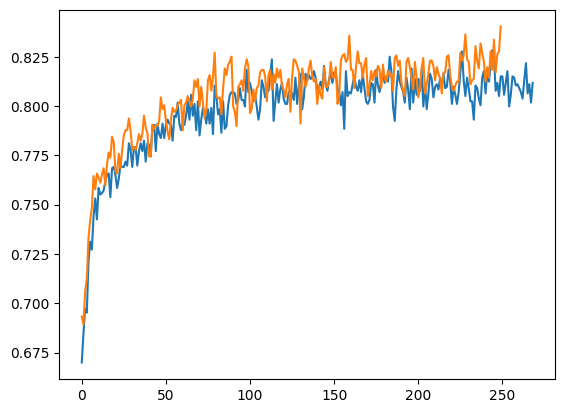

In [16]:
#plt.plot(net.losses)
#plt.plot(torch.load('lossesSCALEBIG7x7'))
plt.plot(net.accs)
plt.plot(torch.load('accsBEST'))

In [15]:
torch.save(net.losses, 'lossesWEIGHT3')
torch.save(net.accs, 'accsWEIGHT3')
torch.save(net.state_dict(), 'dictWEIGHT3')

In [41]:
1 / m.diag()

tensor([1.7176, 1.1230, 1.3469, 1.6667, 1.5914, 1.5714, 1.0556])

<function seaborn.rcmod.set(*args, **kwargs)>

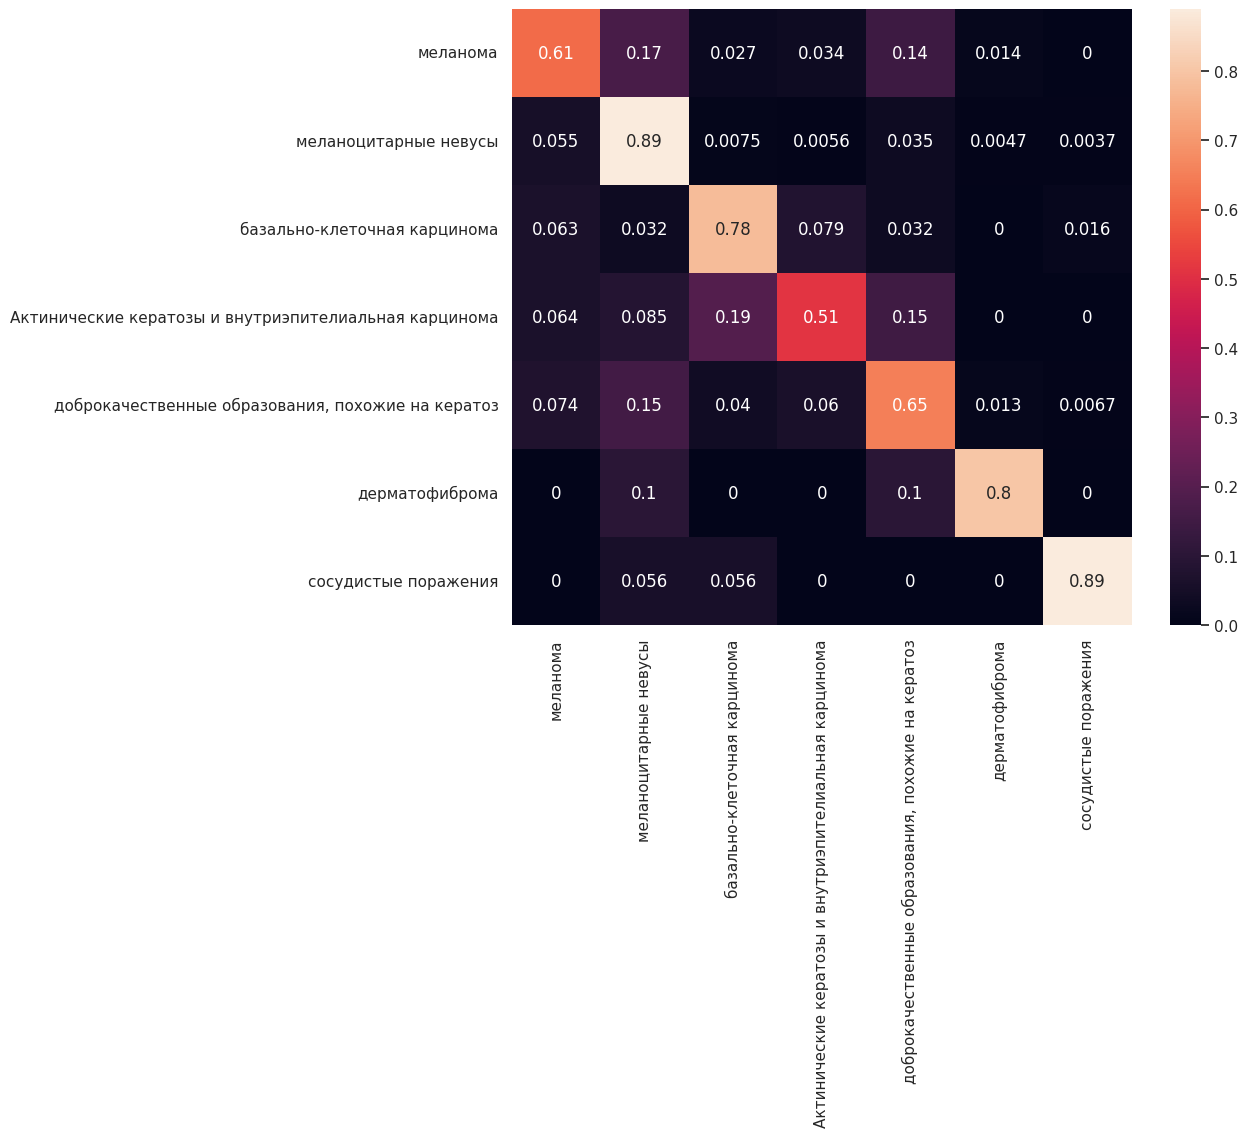

In [20]:
testL = torch.utils.data.DataLoader(test, 64, pin_memory=True)
with torch.no_grad():
    y = torch.tensor([]).to(device)
    p = torch.tensor([]).to(device)
    for t in testL:
        xb, yb = t[0].to(device), t[1].to(device)
        xb = net.cat(xb)
        y = torch.cat((y, yb.argmax(-1)))
        pb = net(xb).argmax(dim=-1)
        p = torch.cat((p, pb))
    p = p.to('cpu').long()
    y = y.to('cpu').long()

matrix = torch.zeros(num_classes, num_classes)
for s in zip(p, y):
    matrix[s[0], s[1]] += 1
m = matrix / matrix.sum(1).unsqueeze(-1)

import seaborn as sns
sns.set(rc={'figure.figsize':(10, 8)})
sns.heatmap(m, annot=True, xticklabels=names, yticklabels=names)
sns.set

Истина: дерматофиброма

Предсказания:
меланома                                               0.0000
меланоцитарные невусы                                  0.0010
базально-клеточная карцинома                           0.0000
Актинические кератозы и внутриэпителиальная карцинома  0.0000
доброкачественные образования, похожие на кератоз      0.0000
дерматофиброма                                         0.9990
сосудистые поражения                                   0.0000


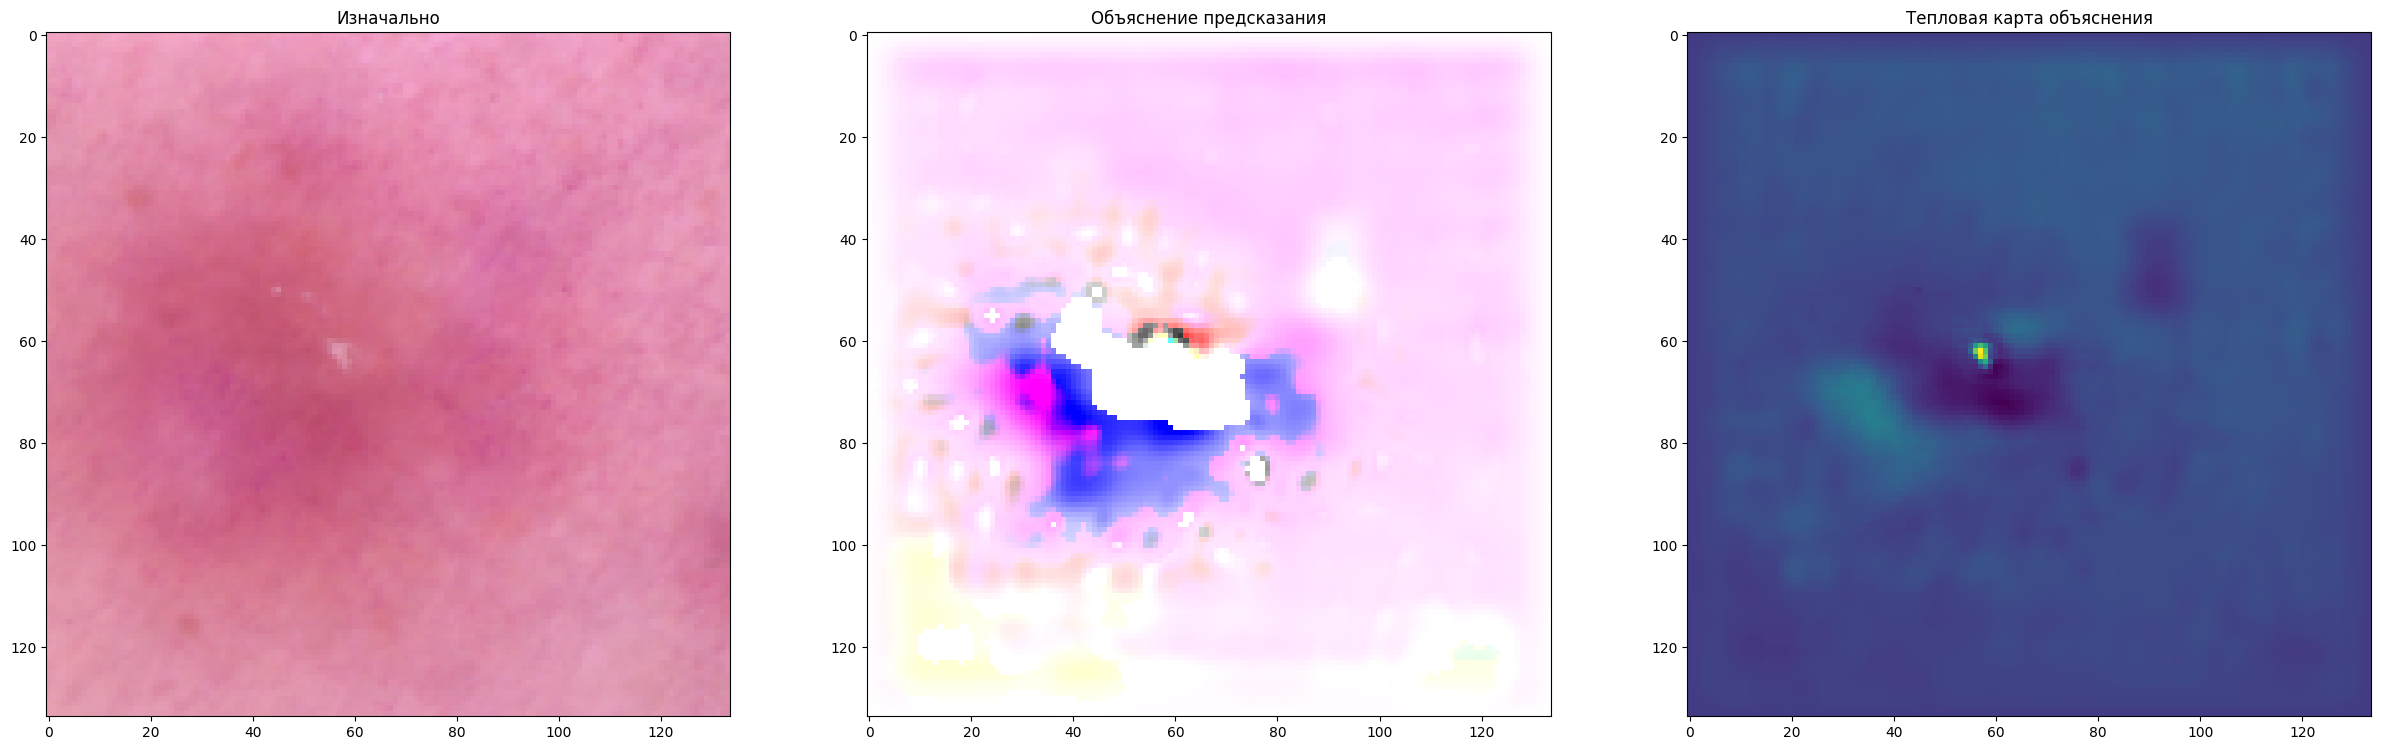

In [19]:
img = 579
y = test[img][1].to(device)
maxi = max(len(d) for d in names)
with torch.no_grad():
    probs = net(net.cat(test[img][0].unsqueeze(0)).to(device))
    probs = torch.softmax(probs, -1).round(decimals=3)
    answers = zip(dictio.values(), probs.tolist()[0])
    print(f'Истина: {dictio[str(y.argmax().item())]}')
    print('')
    print('Предсказания:')
    for i in answers:
        print(i[0], " "*(maxi-len(i[0])), f'{i[1]:.4f}')

y = F.one_hot(torch.tensor(6), num_classes=7)
y = None
maps = net.explain(test[img][0].to(device), y)

fig = plt.figure(figsize=(30, 20))
fig.add_subplot(1, 3, 1)
plt.imshow(maps[2].detach().cpu())
plt.title('Изначально')
fig.add_subplot(1, 3, 2)
plt.imshow(maps[0].detach().cpu())
plt.title('Объяснение предсказания')
fig.add_subplot(1, 3, 3)
plt.imshow(maps[1].detach().cpu())
plt.title('Тепловая карта объяснения')
pass